# Using **solt** to augment keypoints (landmarks) data

In this tutorial, we will shortly demonstrate how to use **solt** with the landmarks data. For that, we will use Helen dataset: http://www.ifp.illinois.edu/~vuongle2/helen/

To run this notebook, please download annotations and test images, and place them into **`Data/helen_annotations`** and **`Data/helen_test_images`** respectively.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import os
import glob
import json

np.random.seed(12345)

In [2]:
import solt.transforms as slt
import solt.core as slc
import solt.data as sld

## Loading and visualizing the image

In [3]:
fname = '3238436027_1.jpg' # Let's just work with this particular image
img = cv2.imread(os.path.join('Data', 'helen_test_images', fname))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
kpts = None
for annotation_fname in glob.glob(os.path.join('Data', 'helen_annotations', '*.txt')):
    with open(annotation_fname) as f:
        if f.readline()[:-1] == fname.split('.')[0]:
            ktps = []
            for l in f:
                tmp = l.split()
                ktps.append([float(tmp[0]), float(tmp[2])])
            break
kpts = np.array(ktps)

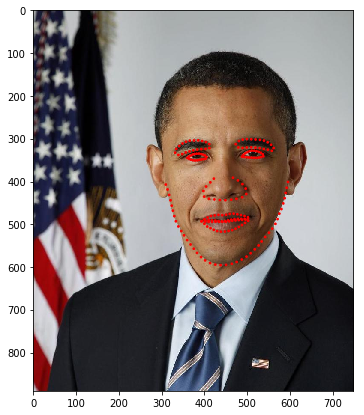

In [5]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1,1,1)
ax.imshow(img)
for k in kpts:
    ax.add_patch(patches.Circle(k, radius=2, color='r'))
plt.show()

## Wrapping the data into **solt** format

In [6]:
# Let's first wrap our keypoints into a keypoints container
kpts_wrapped = sld.KeyPoints(kpts, img.shape[0], img.shape[1])
# Then, we should wrap the image and the created keypoints into a DataContainer
dc = sld.DataContainer((img, kpts_wrapped), 'IP')

## Defining a simple stream and testing it

In [7]:
stream = slc.Stream([
    slt.RandomRotate(rotation_range=(-20, 20), p=1),
    slt.CropTransform(512, crop_mode='r')
])
print(json.dumps(stream.serialize(), indent=4))

{
    "RandomRotate": {
        "indices": null,
        "interpolation": [
            "bilinear",
            "inherit"
        ],
        "p": 1,
        "padding": [
            "z",
            "inherit"
        ],
        "range": [
            -20,
            20
        ]
    },
    "CropTransform": {
        "indices": null,
        "mode": "r",
        "p": 1,
        "size": [
            512,
            512
        ]
    }
}


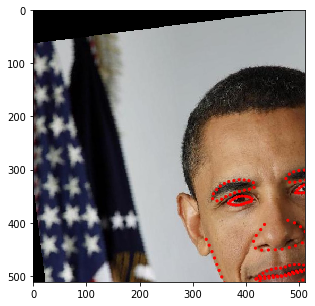

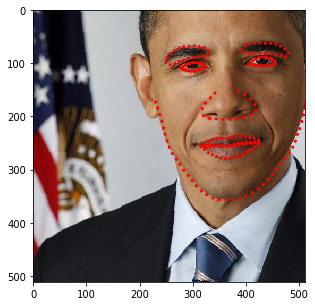

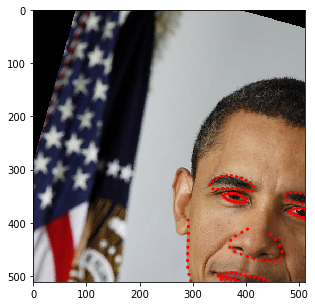

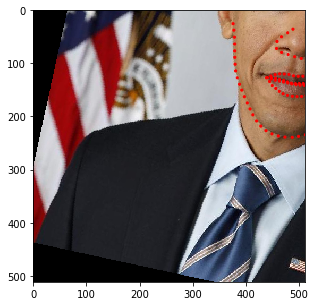

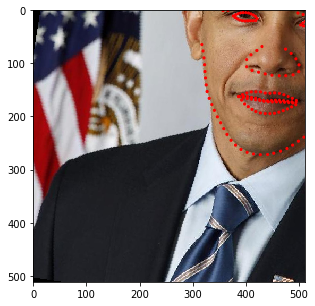

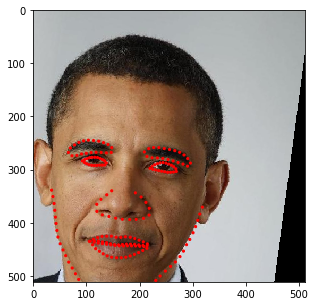

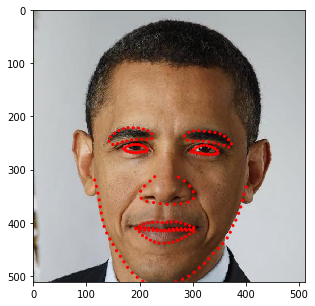

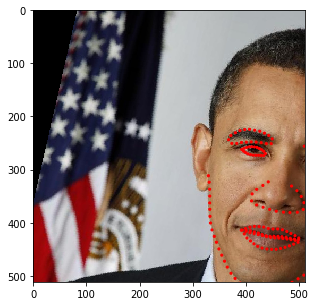

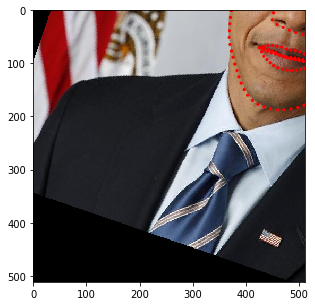

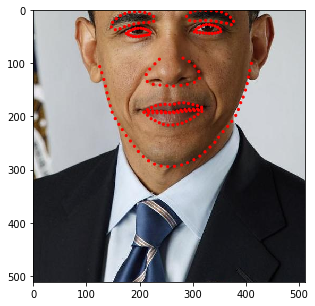

In [8]:
for i in range(10):
    res = stream(dc)
    img_res, kp_res = res.data
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img_res)
    for k in kp_res.data:
        ax.add_patch(patches.Circle(k, radius=2, color='r'))
    plt.show()

You may have noticed that the image size changes depending on the rotation angle. In fact, at this stage, we incorporated such behavior into **solt**.
Let's now define a more complicated pipeline.

In [9]:
stream = slc.Stream([
    slt.RandomProjection(
            slc.Stream([
                slt.RandomScale(range_x=(0.5, 1.3), p=1),
                slt.RandomRotate(rotation_range=(-90, 90), p=1),
                slt.RandomShear(range_x=(-0.5, 0.5), range_y=None, p=1),
        ]), 
        v_range=(1e-6, 9e-4)),
    slt.ImageGammaCorrection(p=0.5, gamma_range=(0.5, 3)),
    slc.SelectiveStream([
        slt.ImageBlur(p=0.5, blur_type='g', k_size=(11, 21, 31), gaussian_sigma=(1, 10)),
        slt.ImageBlur(p=0.5, blur_type='m', k_size=(11, 21, 31)),
    ]),
    slc.SelectiveStream([
        slt.ImageSaltAndPepper(p=1),
        slt.ImageAdditiveGaussianNoise(p=1)
    ]),
    slc.SelectiveStream([
        slt.ImageBlur(p=0.5, blur_type='g', k_size=(11, 21, 31), gaussian_sigma=(1, 10)),
        slt.ImageBlur(p=0.5, blur_type='m', k_size=(11, 21, 31)),
    ]),
    slt.PadTransform(600, 'z'),
    slt.CropTransform(600, crop_mode='c'),
    slt.CropTransform(512, crop_mode='r')
    
])
print(json.dumps(stream.serialize(), indent=4))

{
    "RandomProjection": {
        "indices": null,
        "interpolation": [
            "bilinear",
            "inherit"
        ],
        "p": 0.5,
        "padding": [
            "z",
            "inherit"
        ],
        "transforms": {
            "RandomScale": {
                "indices": null,
                "interpolation": [
                    "bilinear",
                    "inherit"
                ],
                "p": 1,
                "padding": [
                    "z",
                    "inherit"
                ],
                "same": true,
                "x": [
                    0.5,
                    1.3
                ],
                "y": null
            },
            "RandomRotate": {
                "indices": null,
                "interpolation": [
                    "bilinear",
                    "inherit"
                ],
                "p": 1,
                "padding": [
                    "z",
                    "inher

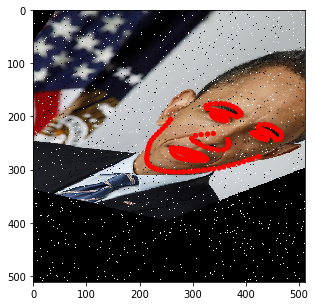

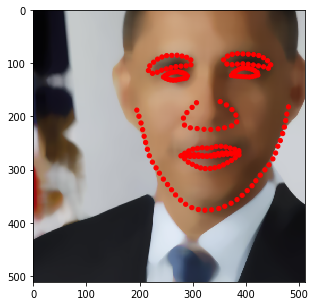

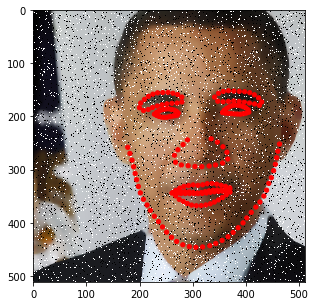

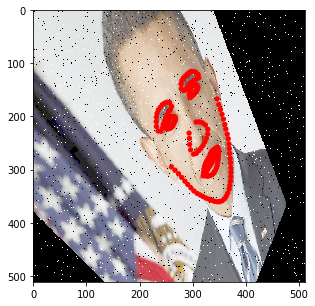

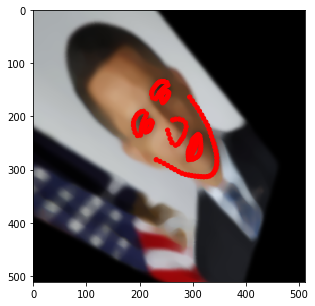

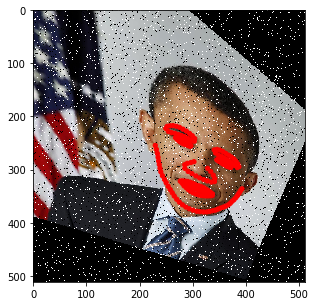

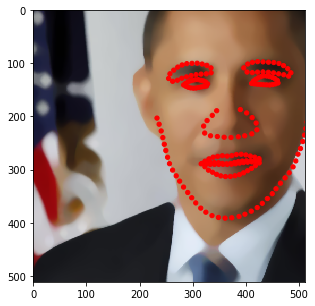

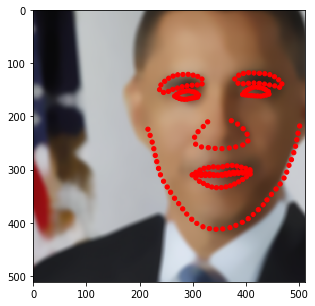

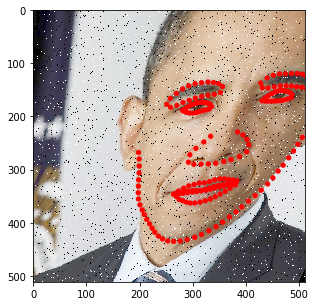

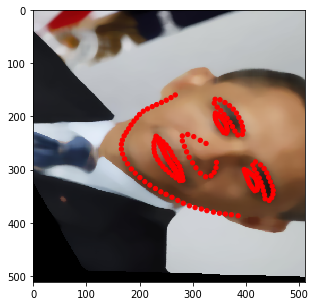

In [10]:
for i in range(10):
    res = stream(dc)
    img_res, kp_res = res.data
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img_res)
    for k in kp_res.data:
        ax.add_patch(patches.Circle(k, radius=4, color='r'))
    plt.show()